# Prévalence du Listeria dans le lait cru

In [1]:
!ls

README.md                 listeria.txt              projets2021.pdf
exploratoire_claire.ipynb mcmc.ipynb


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as rd

In [8]:
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)

In [9]:
data['prob']=data["nb_pos"]/data['nb_test']
proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])

In [10]:
proba_constante

0.0010564383073439964

# Question 1 : détermination de la loi a posteriori

On suppose dans un premier temps que la probabilité de présence de listeria dans toutes les études est constante. 

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p)$, de fonction de masse $f(r_i, p) = \binom{n_i}{r_i} p^{r_i} (1-p)^{n_i-r_i}$ 

Loi a priori : $p \sim \mathcal{B}eta(\alpha,\beta)$ avec $\alpha, \beta = 1$ ce qui revient à avoir $p \propto \mathcal{U}([0,1])$ donc de densité $\mathbb{1}_{[0,1]}(p)$

La densité de la loi a posteriori est alors ($n$=91 est le nombre d'études) : 

$\pi(p|r_1,\dots, r_n) \propto \prod_{i=1}^{n}f(r_i,p) \mathbb{1}_{[0,1]}(p) 
\\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \prod_{i=1}^{n} p^{r_i} (1-p)^{(n_i-r_i)}  
\\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto p^{\sum_{i=1}^{n}r_i} (1-p)^{\sum_{i=1}^{n}(n_i-r_i)}  \sim \mathcal{B}eta(\sum_{i=1}^{n}r_i +1, \sum_{i=1}^{n}(n_i-r_i)+1)$

Les observations nous permettent alors de calculer les deux paramètres de cette loi Bêta :


In [15]:
print("premier paramètre =",sum(data['nb_pos'])+1)
print("deuxième paramètre =",sum(data['nb_test'])-sum(data['nb_pos'])+1)

premier paramètre = 1329
deuxième paramètre = 1255727


Finalement, la loi a posteriori de $p$ est une $\boxed{\mathcal{B}eta(1329,1255727)}$

# Question 2 

On suppose dans un second temps que la probabilité de présence de listeria est variable selon les études.  

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p_i)$, de fonction de masse $f(r_i, p_i) = \binom{n_i}{r_i} p_i^{r_i} (1-p_i)^{n_i-r_i}$

Loi a priori : $ \forall i, p_i \sim \mathcal{B}eta(\alpha,\beta)$, de densité $\displaystyle{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}}p_i^{\alpha-1}(1-p_i)^{\beta-1}\mathbb{1}_{[0,1]}(p_i)$

L'énoncé propose la reparamétrisation suivante : $\mu = \alpha/(\alpha+\beta) \sim \mathcal{U}([0,1])$ et $\kappa = \alpha + \beta \sim \mathcal{E}(0.1)$

On supposera que : $\textbf{$\kappa$ et $\mu$ sont indépendantes}$ 

Donc on aura la densité jointe de $(\mu,\kappa)$ suivante : $p(\mu,\kappa)$ = $0.1 e^{-0.1\kappa}\mathbb{1}_{[0,1]}(\kappa)$
     
En inversant : $\alpha = \kappa \mu $ et $\beta = \kappa (1-\mu)$

Et donc $p_i$ a pour densité (sachant $\mu$ et $\kappa$) : $p(p_i|\mu,\kappa)$  = $\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}\mathbb{1}_{[0,1]}(p_i)$

La densité de la loi a posteriori est alors : 

$\pi(\mu,\kappa,p_1,...,p_n|r_1,\dots, r_n) \propto \prod_{i=1}^{n}f(r_i,p_i)p(p_i|\mu,\kappa)p(\mu,\kappa)
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \prod_{i=1}^{n} p_i^{r_i} (1-p_i)^{(n_i-r_i)}\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}e^{-0.1\kappa}  
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto e^{-0.1n\kappa}\left(\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}\right)^n\prod_{i=1}^{n} p_i^{r_i+\kappa \mu -1} (1-p_i)^{(n_i-r_i)+\kappa(1-\mu)-1}$ 

Contrairement au cas précédent, la loi a posteriori ne correspond pas à une loi usuelle connue. 
On va alors mettre en oeuvre un algorithme de $\textbf{Metropolis within Gibbs}$ pour simuler cette loi a posteriori, en s'appuyant sur les différentes lois (connues) de nos paramètres $(p_i)_i,\kappa$ et $\mu$.

In [6]:
donnees = []

<AxesSubplot:xlabel='prob', ylabel='Count'>

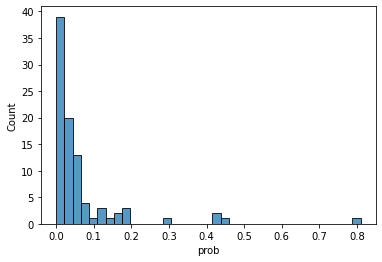

In [7]:
sns.histplot(data, x="prob")

### Loi exponentielle 



In [8]:
def gen_exp(theta):
    u = rd.random()
    return -1/theta*np.log(1-u)

### Loi Gamma 
Remarque : sommer les cas/les études pour un gros échantillon
Simuler une loi beta(alpha, beta) à l'aide de simulation de lois gammas. 

------------
Soient $X$ et $Y$ deux variables independantes distribuees suivant des lois  $\Gamma(a,1)$ et $\Gamma(b,1)$

Alors $U = X+Y$ et $V = X/(X+Y)$ sont deux variables independantes distribuees suivant des lois $\Gamma(a+b,1)$ et $\mathcal{B}eta(a,b)$.





In [9]:
def gamma(x):
    l = [gen_exp(x) for i in range(10000)]
    return mean(l)
        
def f(x, a, b):
    return b**a*x**(a-1)*exp(-bx)/gamma(a)


In [10]:
def gen_gamma(a,b):
    # si alpha = 1, cela revient à avoir une loi exponentielle de paramètre beta
    if a == 1:
        return gen_exp(b)
    # si alpha est un entier non nul, gamma coïncide avec une somme de alpha va exponentielles
    # de paramètre beta indépendantes
    elif a == int(a) and a > 1 : 
        return sum([gen_exp(b) for i in range(a)])
    # sinon, on va utiliser une méthode de rejet 
    else : 
        while True : 
            # on va utiliser une loi de gamma de paramètres entiers pour g
            x = gen_gamma(int(a), b+1)
            # constante calculée dans la photo sur messenger
            c = b**a/((b+1)**int(a))*gamma(int(a))/gamma(a)*(a-int(a))**(a-int(a))*exp(-int(a)+a)
            u = rd.random()
            if u <= c*f(x, a, b)/g(x, int(a), b+1):
                return x 
        
        

In [11]:
def gen_beta(alpha, beta):
    X = gen_gamma(alpha, 1)
    Y = gen_gamma(beta,1)
    return X/(X+Y)

In [12]:
def gen_binomiale(n,p):
    l=[]
    for i in range(n):
        r = rd.random()
        if r <= p:
            l.append(1)
    return sum(l)

In [13]:
def gen_bernoulli(p):
    if rd.random() <= p :
        return 1
    return 0

Représentation graphique 


Loi a posteriori : $\pi(p|r_1,\dots,r_n) \sim \mathcal{B}eta(\sum_i^n r_i+1, \sum_i^n n_i-r_i+1)$

In [38]:
# générateur de la loi a posteriori   
def gen_aposte():
    list_n = data['nb_test'].tolist()
    r_list = []
    for elem in list_n:
        r_list.append(gen_binomiale(elem,proba_constante)) 
    p=gen_beta(sum(r_list)+1, sum(list_n)-sum(r_list)+1)
    x = rd.random()
    if x <= p:
        return x

In [ ]:
distr = [gen_aposte() for i in range(1000)]
sns.histplot(distr)

In [27]:
data

,nb_pos,nb_test,prob
0,0,415,0.000000
1,0,276,0.000000
2,0,220,0.000000
3,0,150,0.000000
4,0,142,0.000000
...,...,...,...
86,6,14,0.428571
87,7,16,0.437500
88,43,95,0.452632
89,17,21,0.809524


<AxesSubplot:xlabel='prob', ylabel='Count'>

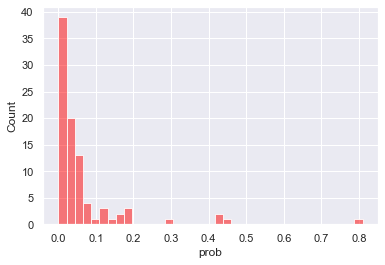

In [31]:
sns.set(style="darkgrid")
#sns.histplot([gen_beta(r_list[i]+1,list_n[i]-r_list[i]+1) for i in range(len(list_n))],color="skyblue", label="model", )
sns.histplot(data['prob'], color="red", label="donnees", alpha=0.5)

In [19]:
list_n = data['nb_test'].tolist()
r_list = []
for elem in list_n:
    p = gen_bernoulli(proba_constante)
    r_list.append(gen_binomiale(elem,p)) 

<AxesSubplot:xlabel='prob', ylabel='Count'>

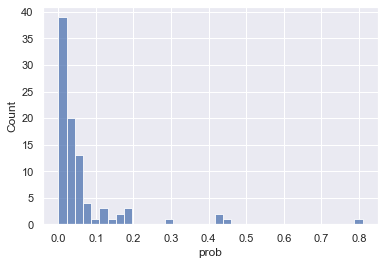

In [20]:
sns.histplot(data['prob'])